# INM707: Basic Tasks

We define an environment where a robot vacuum cleaner navigates through a single-story house, trying to clean the floors of the house. It needs to avoid furniture and walls, whilst trying to clean the floors in the shortest time possible.

The work presented here is part of the coursework of the INM707 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM707).

### Import Libraries

...

In [1]:
# Import Relevant Libraries
import numpy as np
import random
import matplotlib.pyplot as plt

### Set Random Seed

...

In [2]:
randomer = 50

# Random Seed
random.seed(randomer)
np.random.seed(randomer)

### Function to Visualise the Environment

...

In [3]:
# Class for visualising the environment, not strictly necessary but useful to see whether the environment is correctly designed
class Visualiser(object):
    """
    Class to visualise our (Gridworld) environment. We visualise our robot vacuum cleaner environment using this class.
    It requires hyperparameters to be input, which are the grid size (shape), all locations, locations of any obstacles, locations of terminal states (absorbing states),
    the reward obtained from visiting these terminal states, and the default reward for taking an action.
    
    The class is inspired and based on the coursework from a Reinforcement Learning module at Imperial College London, which was given to students to help with their assignments.
    That class can be found here: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.
    """
    def __init__(self, shape, locations, colour, obstacle_locs, terminal_locs, terminal_rewards, terminal):
        self.shape = shape
        self.locations = locations
        self.terminal = terminal
        
        # Obstacles
        self.obstacles = np.zeros(self.shape)
        for ob in obstacle_locs:
            self.obstacles[ob] = 20

        # Rewards
        self.rewarders = np.ones(self.shape) * colour
        for i, rew in enumerate(terminal_locs):
            self.rewarders[rew] = 10 if terminal_rewards[i] > 0 else -10

        # Print the map to show it
        self.paint_maps()

    def paint_maps(self):
        plt.figure(figsize = (15, 10))
        plt.imshow(self.obstacles + self.rewarders)
        plt.show()

    def paint_state(self, state):
        states = np.zeros(self.shape)
        states[state] = 30
        plt.figure(figsize = (15, 10))
        plt.imshow(self.obstacles + self.rewarders + states)
        plt.show()

    def draw_deterministic_policy(self, Policy):
        plt.figure(figsize = (15, 10))
        plt.imshow(self.obstacles + self.rewarders) # Create the graph of the Gridworld
        for state, action in enumerate(Policy):
            if(self.terminal[0, state]): # If it is an terminal state, don't plot any action
                continue
            arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locations[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha = "center", va = "center") # Place it on graph
        plt.show()

    def draw_policy(self, Policy):
        deterministic_policy = np.array([np.argmax(Policy[row, :]) for row in range(Policy.shape[0])])
        self.draw_deterministic_policy(deterministic_policy)

    def draw_value(self, Value):
        plt.figure(figsize = (15, 10))
        plt.imshow(self.obstacles + self.rewarders) # Create the graph of the Gridworld
        for state, value in enumerate(Value):
            if(self.terminal[0, state]): # If it is an terminal state, don't plot any value
                continue
            location = self.locations[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value, 2), ha = "center", va = "center") # Place it on graph
        plt.show()

    def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
        plt.figure(figsize = (20, 8))
        for subplot in range (len(Policies)): # Go through all policies
            ax = plt.subplot(n_columns, n_lines, subplot + 1) # Create a subplot for each policy
            ax.imshow(self.obstacles + self.rewarders) # Create the graph of the Gridworld
            for state, action in enumerate(Policies[subplot]):
                if(self.terminal[0,state]): # If it is an terminal state, don't plot any action
                    continue
                arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
                action_arrow = arrows[action] # Take the corresponding action
                location = self.locations[state] # Compute its location on graph
                plt.text(location[1], location[0], action_arrow, ha = "center", va = "center") # Place it on graph
            ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
        plt.show()

    def draw_policy_grid(self, Policies, title, n_columns, n_lines):
        deterministic_policies = np.array([[np.argmax(Policy[row, :]) for row in range(Policy.shape[0])] for Policy in Policies])
        self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

    def draw_value_grid(self, Values, title, n_columns, n_lines):
        plt.figure(figsize = (20, 8))
        for subplot in range (len(Values)): # Go through all values
            ax = plt.subplot(n_columns, n_lines, subplot + 1) # Create a subplot for each value
            ax.imshow(self.obstacles + self.rewarders) # Create the graph of the Gridworld
            for state, value in enumerate(Values[subplot]):
                if(self.terminal[0, state]): # If it is an terminal state, don't plot any value
                    continue
                location = self.locations[state] # Compute the value location on graph
                plt.text(location[1], location[0], round(value, 1), ha = "center", va = "center") # Place it on graph
            ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

### Environment Creation

...

In [4]:
class Gridworld(object):
    """
    Class to create an environment, which is normally referred to as a Gridworld. We construct our robot vacuum cleaner environment using this class.
    It requires hyperparameters to be input, which are the grid size (shape), locations of any obstacles, locations of terminal states (absorbing states),
    the reward obtained from visiting these terminal states, possible starting locations of the agent, the default reward for taking an action, and finally
    the maximum number of steps the agent can take before the episode ends.
    
    The class is inspired and based on the coursework from a Reinforcement Learning module at Imperial College London, which was given to students to help with their assignments.
    That class can be found here: https://github.com/LorenzoStigliano/imperial-reinforcement-learning/blob/master/Coursework/CW1/coursework_1_maze.ipynb.
    """
    def __init__(self, shape, obstacle_locs, terminal_locs, terminal_rewards, starting_locs, colour, max_time):
        self._shape = shape
        self._obstacle_locs = obstacle_locs
        self._terminal_locs = terminal_locs
        self._terminal_rewards = terminal_rewards
        self._starting_locs = starting_locs
        self._colour = colour
        self._max_time = max_time
        
        # Build the environment
        self._build_Gridworld()

    def _build_Gridworld(self):
        # Four total actions
        self._action_size = 4
        # Up, left, down, right (North, East, South, West)
        self._direction_names = ["N", "E", "S", "W"]
        self._locations = []
        
        for i in range(self._shape[0]):
            for j in range(self._shape[1]):
                loc = (i, j)
                if self._is_location(loc):
                    # Adding the state to locations
                    self._locations.append(loc)

        # Number of locations
        self._state_size = len(self._locations)

        # Each line is a state, with each column a unique action/direction (N, E, S, W)
        self._neighbours = np.zeros((self._state_size, 4)) 

        # Loop over states
        for state in range(self._state_size):
            # Get location of state on grid
            loc = self._get_loc_from_state(state)

            # Moving North
            neighbour = (loc[0] - 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("N")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("N")] = state

            # Moving East
            neighbour = (loc[0], loc[1] + 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("E")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("E")] = state

            # Moving South
            neighbour = (loc[0] + 1, loc[1])
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("S")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("S")] = state
            
            # Moving West
            neighbour = (loc[0], loc[1] - 1)
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index("W")] = self._get_state_from_loc(neighbour)
            else:
                self._neighbours[state][self._direction_names.index("W")] = state

        # Terminal states
        self._terminal = np.zeros((1, self._state_size))
        for a in self._terminal_locs:
            terminal_state = self._get_state_from_loc(a)
            self._terminal[0, terminal_state] = 1

        # Transition Matrix
        self._T = np.zeros((self._state_size, self._state_size, self._action_size))
        # Loop over every action/direction
        for action in range(self._action_size):
            for outcome in range(4):
                if action == outcome:
                    prob = 1
                else:
                    prob = 0
                for prior_state in range(self._state_size):
                    if not self._terminal[0, prior_state]:
                        post_state = self._neighbours[prior_state, outcome]
                        post_state = int(post_state)
                        self._T[prior_state, post_state, action] += prob
        
        self._construct_R()
        
        # Create Gridworld graphics
        self._graphics = Visualiser(self._shape, self._locations, self._colour, self._obstacle_locs, self._terminal_locs, self._terminal_rewards, self._terminal)
        self.reset()

    def _is_location(self, loc):
        if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0] - 1 or loc[1] > self._shape[1] - 1):
            return False
        elif (loc in self._obstacle_locs):
            return True
        else:
            return True
            
    def _construct_R(self):
        # Reward matrix
        # Fill matrix with ones
        self._R = np.ones((self._state_size, self._state_size, self._action_size))
        # Assign rewards of terminal states
        for i in range(len(self._terminal_rewards)):
            post_state = self._get_state_from_loc(self._terminal_locs[i])
            # Assign reward for visiting terminal state
            self._R[:, post_state, :] = self._terminal_rewards[i]

        # Assign negative reward for moving into obstacles or out of the grid
        for obstacle_loc in self._obstacle_locs:
            obstacle_state = self._get_state_from_loc(obstacle_loc)
            # Negative reward for all actions leading to an obstacle
            self._R[:, obstacle_state, :] = -1000
            # No reward for moving from obstacle state to itself
            self._R[obstacle_state, obstacle_state, :] = -1000

        # Get non-obstacle locations and non-terminal locations
        self._non_obstacle_locs = [(i, j) for i in range(self._shape[0]) for j in range(self._shape[1]) 
                     if (i, j) not in self._obstacle_locs 
                     and not self._terminal[0, self._get_state_from_loc((i, j))]]

        # Assign negative reward for moving into obstacles or out of the grid
        for non_obstacle_loc in self._non_obstacle_locs:
            non_obstacle_state = self._get_state_from_loc(non_obstacle_loc)
            # Positive reward for all actions leading to an empty location
            self._R[:, non_obstacle_state, :] = 5

        # Save reward matrix in memory, as it will be changed later during the episode
        self._R_old = self._R
        return self._R_old, self._R
        
    def _get_state_from_loc(self, loc):
        return self._locations.index(tuple(loc))
        
    def _get_loc_from_state(self, state):
        return self._locations[state]
        
    def get_T(self):
        return self._T
        
    def get_R(self):
        return self._R

    def get_terminal(self):
        return self._terminal

    def get_graphics(self):
        return self._graphics

    def get_action_size(self):
        return self._action_size

    def get_state_size(self):
        return self._state_size
        
    def reset(self):
        self._t = 0
        self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
        self._reward = 0
        self._R = self._construct_R()[0]
        self._done = False
        self._visited = set()
        self._visited.add(self._state)
        return self._t, self._state, self._reward, self._done
        
    def step(self, action):
        if self._done:
            print("Please reset the environment")
            return self._t, self._state, self._reward, self._done
        
        # Determine the next state based on the action taken
        new_state = np.argmax(self._T[self._state, :, action])
        
        # Adjust reward matrix if new state reached
        if new_state in self._visited:
            self._reward = -1
            self._R[self._state, new_state, action] = self._reward
            self._visited.add(new_state)
        
        # Setting new t, state, reward and done
        self._t += 1
        self._reward = self._R[self._state, new_state, action]
        self._done = self._terminal[0, new_state] or self._t > self._max_time
        self._state = new_state
            
        return self._t, self._state, self._reward, self._done

### Environment Hyperparameters

...

In [5]:
shape = (6, 6)
obstacle_locs = [(0, 0), (0, 2), (0, 3), (0, 5), (1, 0), (1, 2), (1, 3), (1, 5), (2, 0), (2, 2), (2, 3), (4, 2), (4, 3), (4, 5), (5, 0), (5, 1), (5, 2)]
terminal_locs = [(0, 1)]
terminal_rewards = [50]
starting_locs = [(0, 4), (1, 1), (3, 0), (3, 5), (4, 1), (5, 3), (5, 5)]
colour = -5
max_time = 500

### Defining and Visualising the Environment

The green location represents the terminal/absorbing state, of which there is only one. The robot should ultimately try to go here so it can recharge its battery after cleaning the floors. The yellow locations represent obstacles, of which there are 17. These consists of walls and furniture, details of which can be found in the report. Lastly, the purple locations represent the floors that need to be cleaned, and the robot can visit these locations (18 in total).

Robot Vacuum Cleaner Environment:



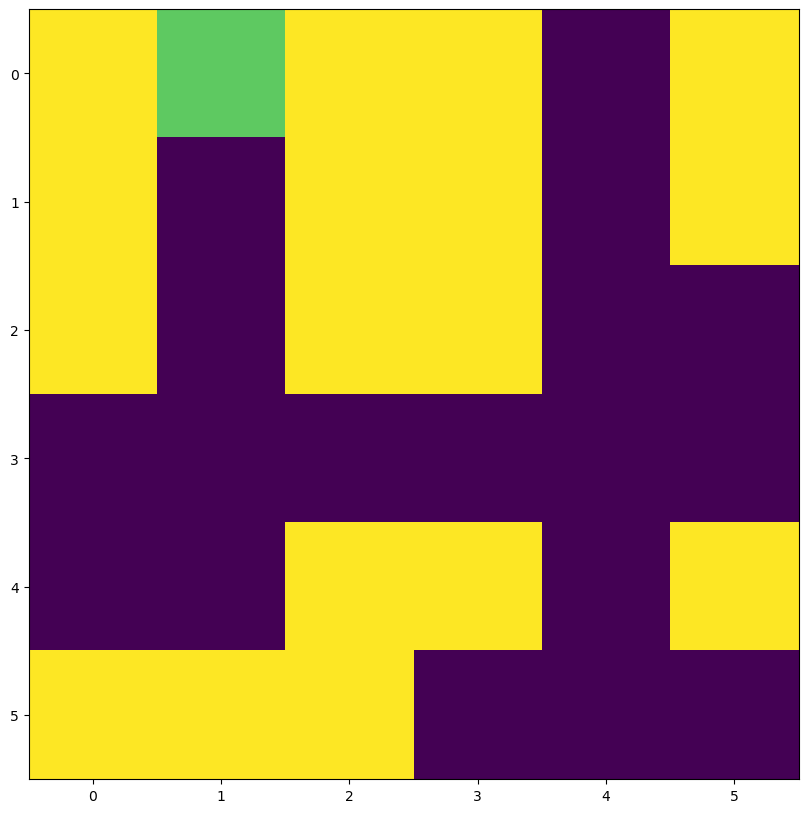

In [6]:
# Create robot vacuum cleaner environment
print("Robot Vacuum Cleaner Environment:\n")
vacuum_environment = Gridworld(shape = shape, obstacle_locs = obstacle_locs, terminal_locs = terminal_locs, terminal_rewards = terminal_rewards, starting_locs = starting_locs, colour = colour, max_time = max_time)

### Transition and Reward Matrices

...

In [7]:
# Transition Matrix
print("Possible Transition Probabilities:", np.unique(vacuum_environment.get_T()))
print("Transition Matrix:\n", vacuum_environment.get_T())

# Reward Matrix (note that the reward for visiting a previous state changes during the episode)
print("Possible Reward Values:", np.unique(vacuum_environment.get_R()))
print("Initial Reward Matrix:\n", vacuum_environment.get_R())

Possible Transition Probabilities: [0. 1.]
Transition Matrix:
 [[[1. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [1. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 1.]
  [0. 1. 1. 0.]]]
Possible Reward Values: [-1000.     5.    50.]
Initial Reward Matrix:
 [[[-1000. -1000. -1000. -1000.]
  [   50.    50.    50.    50.]
  [-1000. -1000. -1000. -1000.]
  ...
  [    5.     5.     5.     5.]
  [    5.     5.     5.     5.]
  [    5.     5.     5.     5.]]

 [[-1000. -1000. -1000. -1000.]
  [ 

### Q-learning Algorithm

In [8]:
class Q_Learner(object):
    """
    Class for the Q-learning algorithm. It requires an environment to run, such as our Gridworld (robot vacuum cleaner) environment.
    It allows for the epsilon-greedy policy to be used, a standard greedy policy, an agent to be trained on the environment through Q-learning,
    and for the agent to be evaluated after training (running the final trained Q-table on many episodes, and taking the mean and standard deviation
    of the final reward in each episode).
    """
    def epsilon_greedy(self, env, Q_table, s, epsilon):
        # Get size of action space
        action_size = env.get_action_size()
        # Get possible actions
        actions = [action for action in range(action_size)]
        # Find optimal action
        optimal_action = np.argmax(Q_table[s, :])
        # Get single random number (could use random.uniform(0, 1))
        random_int = np.random.rand(1)[0]
    
        if random_int >= epsilon:
            return optimal_action
        else:
            other_actions = [a for a in actions if a != optimal_action]
            return np.random.choice(other_actions)

    def get_greedy_policy(self, env, Q_table, policy):
        states = env.get_state_size()
        for s in range(states):
            optimal_action = np.argmax(Q_table[s, :])
            policy[s, optimal_action] = 1
        return policy
    
    def train(self, env, Q_table, total_episodes, min_epsilon, max_epsilon, decay_rate, gamma, alpha):
        episode_rewards = []
        time_stamps = []
        final_values = [np.zeros(env.get_state_size())]
        for episode in range(total_episodes):
            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(- decay_rate * episode)
            rewards = 0
            V = final_values[-1].copy()
            t_, s_t, reward_, done_ = env.reset()
            
            while not done_:
                a_t = self.epsilon_greedy(env, Q_table, s_t, epsilon)
                t, s_t_1, r_t_1, done_ = env.step(a_t)

                Q_table[s_t, a_t] += alpha * (r_t_1 + gamma * max(Q_table[s_t_1, :]) - Q_table[s_t, a_t])
                V[s_t] += alpha * (r_t_1 - V[s_t] + gamma * V[s_t_1])
          
                rewards += r_t_1
                s_t = s_t_1
        
            episode_rewards.append(rewards)
            time_stamps.append(t)
            final_values.append(V)

        final_policy = np.zeros((env.get_state_size(), env.get_action_size()))
        final_policy = self.get_greedy_policy(env, Q_table, final_policy)
      
        return final_policy, final_values, episode_rewards, time_stamps, Q_table

    def evaluate(self, env, Q_table, total_episodes):
        episode_rewards = []
        for episode in range(total_episodes):
            t_, s_t, reward_, done_ = env.reset()
            rewards = 0
            
            while not done_:
                a_t = np.argmax(Q_table[s_t, :])
                t, s_t_1, r_t_1, done_ = env.step(a_t)
                
                rewards += r_t_1
                s_t = s_t_1
                
            episode_rewards.append(rewards)

        mean_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)
      
        return mean_reward, std_reward, episode_rewards

### Initial Q-learning Hyperparameters

...

In [9]:
# Q-learning parameters
gamma = 0.8
alpha = 0.6
total_episodes = 10000

# Exploration-Exploitation parameters
max_epsilon = 0.9
min_epsilon = 0.05
decay_rate = 0.0005

# Set Initial Q-table (we use random numbers from a uniform [0, 1) distribution, but zeroes work too)
Q_table = np.random.rand(vacuum_environment.get_state_size(), vacuum_environment.get_action_size())

### Initial Results

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

Q-learning Final Policy and Policy Values:



findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


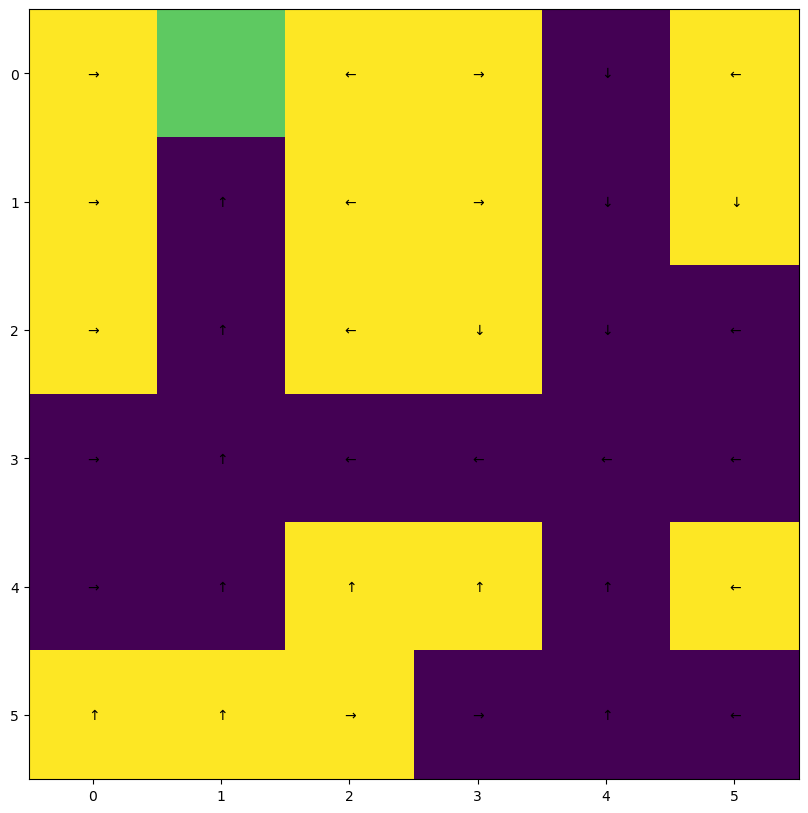

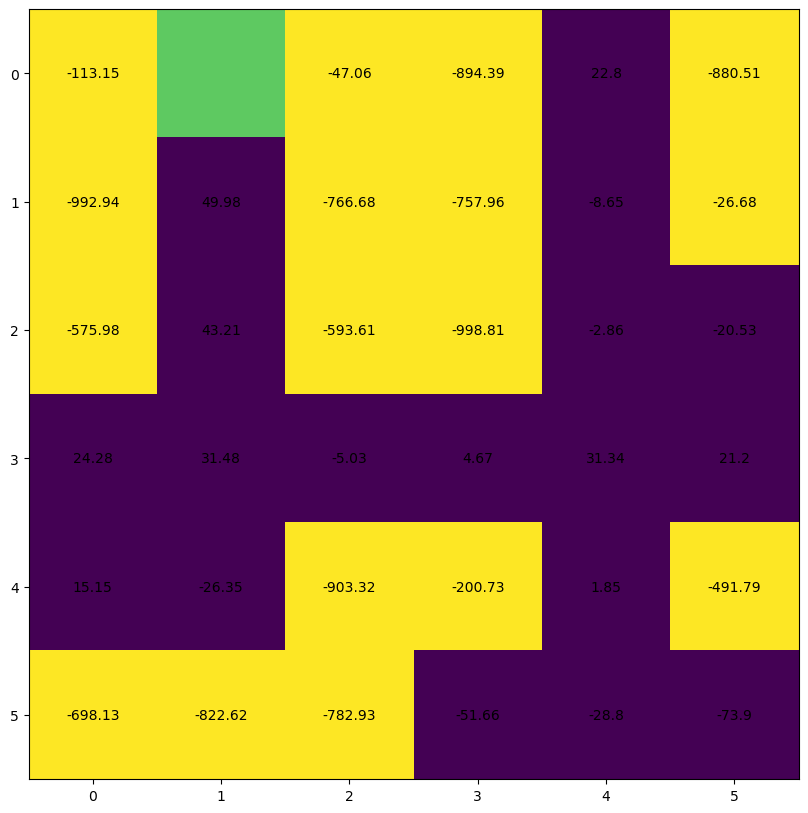

In [10]:
# Set seed again (if needed)
np.random.seed(50)
random.seed(50)

# Create class object for Q-learning
initial_q_learning = Q_Learner()
# Train an agent on the environment through Q-learning
final_policy, final_values, total_rewards, time_stamps, Q_table = initial_q_learning.train(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes, min_epsilon = min_epsilon, max_epsilon = max_epsilon, decay_rate = decay_rate, gamma = gamma, alpha = alpha)

# Use the Gridworld graphics class to draw the policy and policy values for each state
print("Q-learning Final Policy and Policy Values:\n")
vacuum_environment.get_graphics().draw_policy(final_policy)
vacuum_environment.get_graphics().draw_value(final_values[-1])

### Evaluate Initial Results

...

In [11]:
# Gather statistics of agent evaluation
mean_reward, std_reward, episode_rewards = initial_q_learning.evaluate(env = vacuum_environment, Q_table = Q_table, total_episodes = total_episodes)
print("Mean of Episode Rewards:", mean_reward)
print("Standard Deviation of Episode Rewards:", std_reward)

Mean of Episode Rewards: 75.6575
Standard Deviation of Episode Rewards: 14.673622379971484


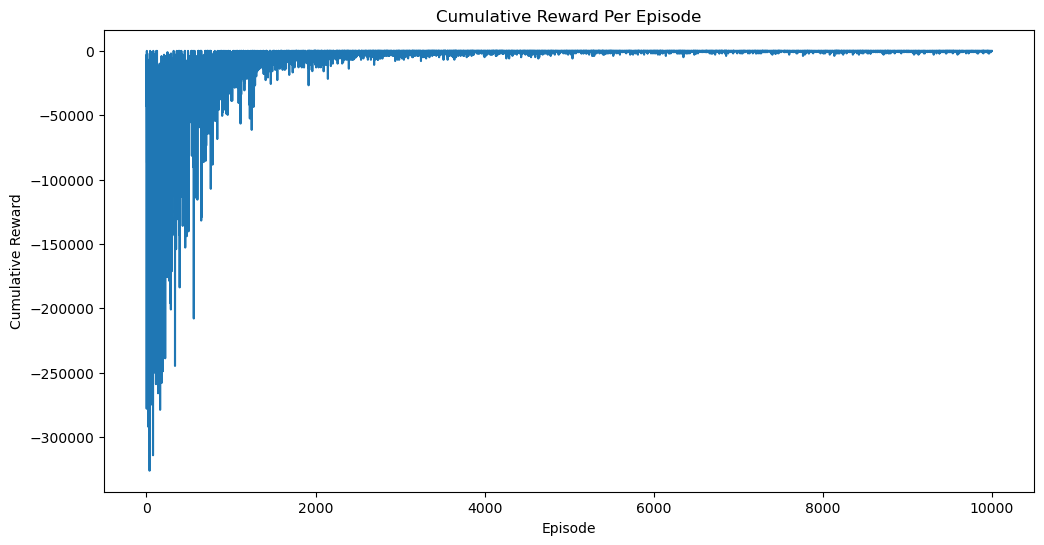

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(total_rewards)
plt.title("Cumulative Reward Per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("initial_q_reward.pdf")
plt.show()

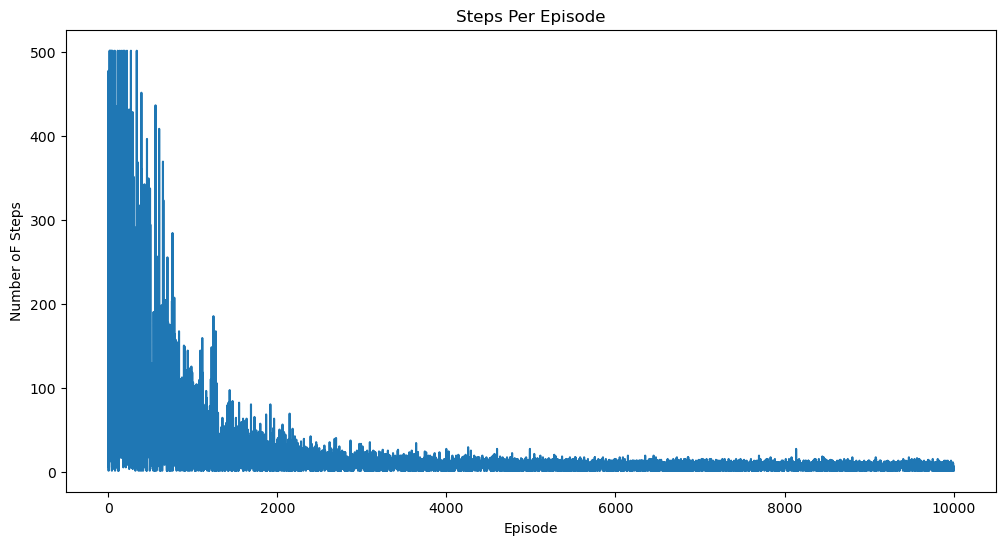

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(time_stamps)
plt.title("Steps Per Episode")
plt.xlabel("Episode")
plt.ylabel("Number oF Steps")
plt.savefig("initial_q_steps.pdf")
plt.show()